In [9]:
from typing import Annotated, List

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage



class State(TypedDict):

    #messages: Annotated[list, add_messages]
    """
    Estado del grafo: historial de mensajes.
    """
    messages: Annotated[List[BaseMessage], add_messages]


In [12]:
from langchain_community.chat_models import ChatOpenAI
from langchain.schema import HumanMessage
from src.app.utils.state import State
from src.app.utils.tools import get_menu_items, create_reservation
from langgraph.graph import StateGraph, START, END
from langchain.schema import HumanMessage, AIMessage
from langchain_core import tool
from src.app.utils.tools import get_menu
from src.app.utils.prompts import SYSTEM_PROMPT, WELCOME_MESSAGE
from langgraph.prebuilt import ToolNode


# Configurar el modelo de OpenAI
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.5)
llm_with_tools = llm.bind_tools([get_menu])

# Nodo humano: recibe mensajes del usuario
def human_node(state: State) -> State:
    """
    Nodo que recibe el input del usuario.
    """
    return state  # Devuelve el estado tal como está

# Nodo principal del chatbot
def chatbot_node(state: State) -> State:
    """
    Nodo que procesa los mensajes y decide si llamar una herramienta.
    """
    messages = state["messages"]
    response = llm_with_tools.invoke([{"role": "system", "content": SYSTEM_PROMPT}] + messages)
    return {"messages": messages + [response]}

# Nodo de herramientas: ejecuta herramientas solicitadas
tool_node = ToolNode([get_menu])


ImportError: cannot import name 'State' from 'src.app.utils.state' (c:\Users\AliciaSanJuliánFerna\Documents\Python\restaurant-app\src\app\utils\state.py)

In [ ]:
from datetime import datetime, time
from sqlalchemy.orm import Session
from src.app.models.restaurant import MenuItem, Reservation
from src.app.databse.database import get_db
from langchain_core import tool

@tool
def get_menu_items() -> str:
    """Obtiene los ítems del menú desde la base de datos."""
    # Obtener una sesión de la base de datos desde get_db
    with next(get_db()) as db:  # Usar next() para manejar el generador
        items = db.query(MenuItem).all()
        if not items:
            return "El menú está vacío."
        menu = "\n".join([f"{item.name} - {item.price}€" for item in items])
    return f"Este es el menú actual:\n{menu}"

@tool
def get_menu() -> str:
    """Devuelve el menú actual del restaurante."""
    with next(get_db()) as db:
        items = db.query(MenuItem).all()
        if not items:
            return "El menú está vacío en este momento."
        return "\n".join([f"{item.name} - {item.price}€" for item in items])

@tool
def create_reservation(name: str, guests: int) -> str:
    """Crea una reserva en la base de datos."""
    # Fecha y hora por defecto
    default_date = datetime.today().date()  # Fecha actual
    default_time = time(hour=19, minute=0)  # Hora predeterminada para reservas
    default_table_capacity = guests  # Supongamos que el tamaño de la mesa coincide con los invitados

    with next(get_db()) as db:  # Usar next() para manejar el generador
        new_reservation = Reservation(
            restaurant_id=1,  # Simulación de un restaurante único
            name=name,
            date=default_date,
            time=default_time,
            guests=guests,
            table_capacity=default_table_capacity
        )
        db.add(new_reservation)
        db.commit()
    return f"Reserva creada con éxito para {name}, {guests} personas, el {default_date} a las {default_time}."


In [ ]:
from langgraph.graph import StateGraph, END, START

from langgraph.graph import StateGraph, START, END
from src.app.utils.state import State
from src.app.utils.nodes import chatbot





from langgraph.graph import StateGraph, START, END
from src.app.utils.state import State
from src.app.utils.nodes import chatbot_node, human_node, tool_node

# Función de enrutamiento
def route_to_tools_or_human(state: State) -> str:
    """
    Decide si ir al tool_node o al human_node basado en la presencia de tool_calls.
    """
    last_message = state["messages"][-1]
    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
        return "tools"
    return "human"

# Crear el grafo
builder = StateGraph(State)

# Añadir nodos
builder.add_node("chatbot", chatbot_node)
builder.add_node("tools", tool_node)
builder.add_node("human", human_node)

# Configurar transiciones
builder.add_conditional_edges("chatbot", route_to_tools_or_human)
builder.add_edge("tools", "chatbot")
builder.add_edge("human", "chatbot")
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

# Compilar el grafo
chat_graph = builder.compile()

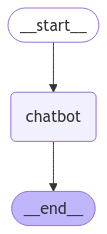

In [7]:
from IPython.display import Image, display

Image(chat_graph.get_graph().draw_mermaid_png())

In [8]:
from src.app.utils.tools import get_menu_items

print(get_menu_items())


Este es el menú actual:
Bruschetta - 5.5€
Caprese - 8.0€
Spaghetti Carbonara - 12.0€
Risotto ai Funghi - 14.0€
Tiramisù - 6.5€
Panna Cotta - 5.5€
